Title : Child Seat Localization

Goal
Build AI solution for child seat localization in the passenger vehicle

Problem statement
Localization of the child seat in the passenger vehicle enable the buisness to high-level services and usecases. 


Data set
The data set shall be https://sviro.kl.dfki.de/data/ or any appropriate data set. You will have to register with an account here. It takes a day to get the approval so start with registering yourself first. 
It’s a synthetic dataset with different images including RGB, Infrared and Bounding Box ground truths.


*Solution scope*
We propose to use Jupyter Notebook with proper markdown text to explain your thought process and logic.  
Proposed software solution shall have following components:

    1. Instrument the data set – Exploratory Analysis
    
    2. State or use prior work from academic / industry
    
    3. Use appropriate state of the art AI algorithm (preferably deep learning based)
    
    4. Enhance the data with synthetic images based on need and your algorithm (optional)
    
    5. Reasonable accuracy on the given scope of time to develop
    
    6. Rationales for the current Approach to enhance 
    
    7. Use any appropriate open source libraries and framework
    
    8. Foucs more on the algorithm than the overall application
    
    9. Apply coding standards and best practices (We emphasize on clean code)
    
    10. Make sure to give proper credits at the end (For example, citation for the dataset used in this challenge)
    
    
*Delivery*

    • The solution shall be presented github / gitlab code with optional supported document in email.
    
    • Execute all the cells of your notebook and export it to PDF. Include it in your source code repository. 
    
    • Prepare a 30 minute presentation on your solution describing challenges faced, choice of algorithms, results of your analysis and illustrations.

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from glob import glob
from tqdm.notebook import tqdm
import os
import shutil
import random
import json

from utils.general import get_coords, extract_from_txt, convert_to_yolov5, generate_json_coco, save_one_json, unconvert
from utils.plots import plot_one_box, plot_image_cropped_new

%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/home/jm/anaconda3/envs/yolo/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


## Dataset exploratory analysis

The dataset is sintetic, meaning made of image that were rendered based on real models and is divided in 10 example of cars and 4 classes, being infant seat, child seat, person and every day object. To compose the dataset I have downloaded only the RGB images, and chose the first 6 cars, summing up a total of 12000 images. From those, 10%, 1200 images were randomly selected and moved to validation. The test set is already separeted within each zip file, and it was added to the test folder.

The dataset is supposed to be separated in train, val and test, in a folder named images, inside the dataset folder, and the labels, which is in the xyxy format is supposed to be in a folder named labels_xyxy, inside the dataset folder, also in the train, val, test fashion, matching the names of the files '.png' and '.txt'.

In [2]:
# Support paths and label dictionary
image_path = './dataset/images/'
label_path = './dataset/labels_xyxy/'

labels_dict = {0: 'infant seat',
               1: 'child seat',
               2: 'person',
               3: 'everyday object'}

# All dataset files, for visualization
all_imgs = glob('./dataset/images/train/*.*')
all_labels = glob('./dataset/labels_xyxy/train/*.*')

In [3]:
# Get all the labels to check for quantity
label_hist = list()
for label in all_labels:
    info = get_coords(label)
    try:
        for l in info[:,0].tolist():
            label_hist.append(l-1)
    except:
        continue

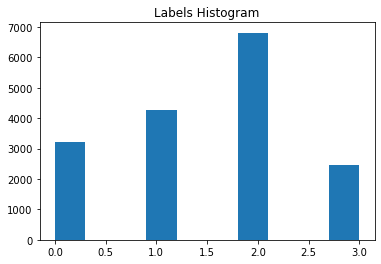

In [4]:
# Plot labels histogram
plt.hist(label_hist)
plt.title('Labels Histogram')
plt.show()

In this Histogram we can see that we have more examples of person, and a lot less of every day objects, which shows an inbalanced dataset.

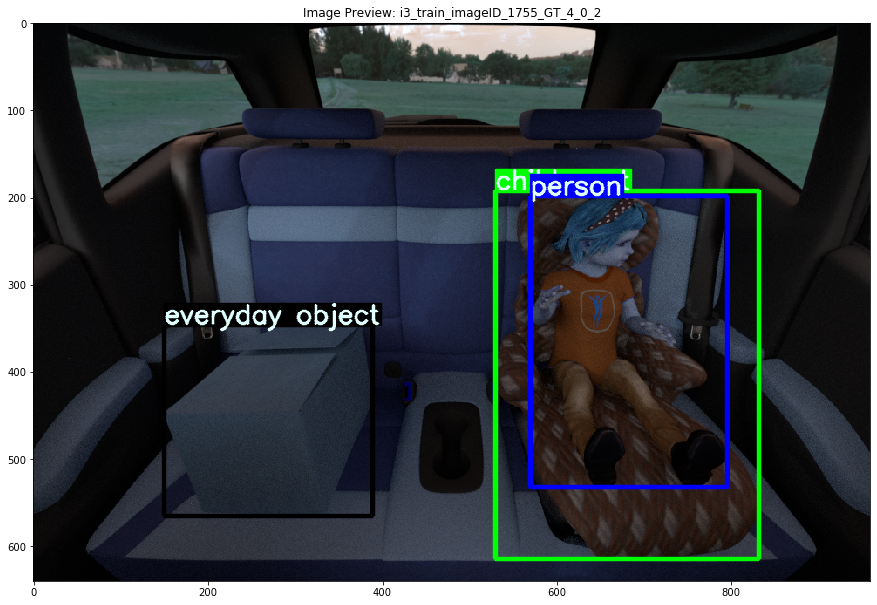

In [5]:
# Get a random image from train set and plot to check

# Get random image and name
img_num = np.random.choice(len(all_imgs))
img_name = all_imgs[img_num].split('/')[-1].split('.')[0]

# Open the image with OpenCV
pic = cv2.imread(image_path + 'train/' + img_name + '.png')

# Get image box coordenates
box_coords_true = np.array(get_coords(label_path + 'train/' + img_name + '.txt'))
box_coords_true[:,0] = box_coords_true[:,0]-1

# Plot image
returned_true = plot_image_cropped_new(pic, box_coords_true)
plt.figure(figsize=(15,15))
plt.title('Image Preview: {}'.format(img_name))
plt.imshow(returned_true)
plt.show()

# Related work on SVIRO

The Academic related on SVIRO described in "SVIRO: Synthetic Vehicle Interior Rear Seat Occupancy Dataset and Benchmark", was more on the CLassification task where it classsified the cropped images, based on 3 parts of the back of the vehicle, and also semantic segmentation, where it used a fine tuned Mask RCNN with a ResNet-50 backbone to achieve the task. For my project, to reach the goal of object detection for the child seat, I chose to use the Yolo approach, where now it is on version v5.

# State of the Art in Object Detection

With the advances in the usage of Transformers, which had a great impact with Natural Language Processing, the same idea is now used in Computer Vision, and Facebook AI have developed a new Vision Transformers, called Detectron2, which now holds the SOTA in Object Detection, prior works are the You Only Look Once, or YOLO for short, that had the best scores on COCO dataset, with also a great inference time and FasterRCNN, that differently from those single shot detection methods, it uses a Region Proposal Network for the bounding box regions.

For this project, as I stated before, I decided to use the YOLO algorithm as I am familiar with and has a great performance and can be trained in smaller GPUs or even CPUs with the smallest model. I also have experience with the FasterRCNN model with a ResNet50 or mobilenetV2 backbone, but as it takes longer to converge, Yolo seems the best option, as also the available code is well maintained and complete, giving you several metrics while training and also image augmentations.

# Yolo algorithm - Training the model with the Yolov5 repository

The algorithm expects the .yaml file inside the data to have the following informations:

```
train: ./dataset/images/train/ 
val:  ./dataset/images/val/
test: ./dataset/images/test/

# number of classes
nc: 4

# class names
names: ["infant seat", "child seat", "person", "everyday object"]
```

Also the labels, had to be in the xywh format, instead of the xyxy that is the current annotation format.

In [11]:
# Preparing the dataset for the yolo requirements - xyxy to xywh

# Convert and save the annotations
task = 'train/'
all_txt = glob('./dataset/labels_xyxy/' + task + '*.txt')
for txt in tqdm(all_txt, desc='Converting Train'):
    info_dict = extract_from_txt(txt, task=task)
    convert_to_yolov5(info_dict, task)

# Convert and save the annotations
task = 'val/'
all_txt = glob('./dataset/labels_xyxy/' + task + '*.txt')
for txt in tqdm(all_txt, desc='Converting Val'):
    info_dict = extract_from_txt(txt, task=task)
    convert_to_yolov5(info_dict, task)
    
# Convert and save the annotations
task = 'test/'
all_txt = glob('./dataset/labels_xyxy/' + task + '*.txt')
for txt in tqdm(all_txt, desc='Converting Test'):
    info_dict = extract_from_txt(txt, task=task)
    convert_to_yolov5(info_dict, task)

Converting Train:   0%|          | 0/7182 [00:00<?, ?it/s]

Converting Val:   0%|          | 0/1200 [00:00<?, ?it/s]

Converting Test:   0%|          | 0/1500 [00:00<?, ?it/s]

In [12]:
# Generate Json for COCO Eval - to be able to use the same metrics as it was used by the SVIRO team

# Annotations JSON generation
all_dataset = glob('./dataset/images/*/*.png')

json_dict = generate_json_coco(all_dataset)

anno_json = 'annotations.json'  # predictions json
print(f'\nSaving {anno_json}...')
with open(anno_json, 'w') as f:
    json.dump(json_dict, f)

Generating Json: 100%|██████████| 9882/9882 [00:09<00:00, 1090.74it/s]



Saving annotations.json...


### Training the model with a resized image of 640x640, with the pre trained weights for the small yolo, for 1 epoch. ( I have trained a model in the Google Colab, to be able to use the GPU and train for more Epochs. )
The Jupyter notebook is also in the repository named Yolov5_bosh_colab_train.ipynb

In [13]:
!python train.py --img 640 --cfg models/yolov5s.yaml --hyp data/hyps/hyp.scratch.yaml --batch 16 --epochs 6 --data /data/cust_detect.yaml --weights yolov5s.pt --workers 8 --name cust_bosh


Bad key "text.kerning_factor" on line 4 in
/home/jm/anaconda3/envs/yolo/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution
train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=/data/cust_detect.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=6, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache_images=False, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, entity=None, name=cust_bosh, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1
github: skipping check (not a git repository), for updates see https://github.com/ultr

### Validation of the model, using the images in the val folder, with the previous trained model, saving the predicted values in a txt toi be used in the COCOtools eval.

In [15]:
!python val.py --img 640 --batch 16 --data /data/cust_detect.yaml --weights runs/train/cust_bosh/weights/best.pt --name val_bosh --save-txt --save-conf


Bad key "text.kerning_factor" on line 4 in
/home/jm/anaconda3/envs/yolo/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution
val: data=./data/cust_detect.yaml, weights=['runs/train/cust_bosh/weights/best.pt'], batch_size=16, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=val, device=, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=True, save_json=False, project=runs/val, name=val_bosh, exist_ok=False, half=False
YOLOv5 🚀 2021-7-28 torch 1.8.1+cu102 CPU

Fusing layers... 
Model Summary: 224 layers, 7062001 parameters, 0 gradients, 16.4 GFLOPs
val: Scanning 'dataset/labels/val.cache' images and labels... 1200 found, 0 miss
               Class     Images     Labels          P          R     mAP@.5 mAP@
                 all       1200

### Results of the model trained with more images on colab

In [16]:
!python val.py --img 640 --batch 16 --data /data/cust_detect.yaml --weights best_colab.pt --task test --name test_bosh_colab --save-txt --save-conf


Bad key "text.kerning_factor" on line 4 in
/home/jm/anaconda3/envs/yolo/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution
val: data=./data/cust_detect.yaml, weights=['best_colab.pt'], batch_size=16, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=test, device=, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=True, save_json=False, project=runs/val, name=test_bosh_colab, exist_ok=False, half=False
YOLOv5 🚀 2021-7-28 torch 1.8.1+cu102 CPU

Fusing layers... 
Model Summary: 224 layers, 7062001 parameters, 0 gradients, 16.4 GFLOPs
test: Scanning 'dataset/labels/test' images and labels...1500 found, 0 missing, 
test: New cache created: dataset/labels/test.cache
               Class     Images     Labels          P          R     mAP@.5 

## Visualizing the result via COCO eval tools

In [17]:
# read txt and append to jdict
txt_files = glob('./runs/val/test_bosh_colab/labels/*.txt')

In [18]:
# Opening JSON file
f = open('annotations.json')
  
# returns JSON object as 
# a dictionary
data_json = json.load(f)
  
# Closing file
f.close()

In [19]:
jdict = []
all_ids = []

for files in txt_files:
    l_list = list()
    box_coords_pred = list()
    r_labels = pd.read_table(files, names=['infos']).values.tolist()
    for b in r_labels:
        label, x, y, w, h, score = list(map(float, b[0].split()))
        x1, y1, x2, y2 = unconvert(640, 640, x, y, w, h)
        l_list.append([label, x1, y1, x2, y2, score])
        if score > 0.5:
            box_coords_pred.append([label, x1, y1, x2, y2])
    save_one_json(np.array(l_list), jdict, files, data_json, all_ids)

In [20]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

if True and len(jdict):
    pred_json = 'predictions.json'  # predictions json
    print(f'\nEvaluating pycocotools mAP... saving {pred_json}...')
    with open(pred_json, 'w') as f:
        json.dump(jdict, f)
        
    anno_json = 'annotations.json'  # predictions json
    print(f'\nEvaluating pycocotools mAP... saving {anno_json}...')
    try:  # https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoEvalDemo.ipynb
        anno = COCO(anno_json)  # init annotations api
        pred = anno.loadRes(pred_json)  # init predictions api
        eval = COCOeval(anno, pred, 'bbox')
        eval.params.imgIds = all_ids  # image IDs to evaluate
        eval.evaluate()
        eval.accumulate()
        eval.summarize()
        map_, map50 = eval.stats[:2]  # update results (mAP@0.5:0.95, mAP@0.5)
    except Exception as e:
        print(f'pycocotools unable to run: {e}')


Evaluating pycocotools mAP... saving predictions.json...

Evaluating pycocotools mAP... saving annotations.json...
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
Loading and preparing results...
DONE (t=2.19s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=7.34s).
Accumulating evaluation results...
DONE (t=1.24s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.217
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.286
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.235
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.218
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.396
 Average Recall     (AR) @[

## Visualizing some predicted bounding boxes with the respective image

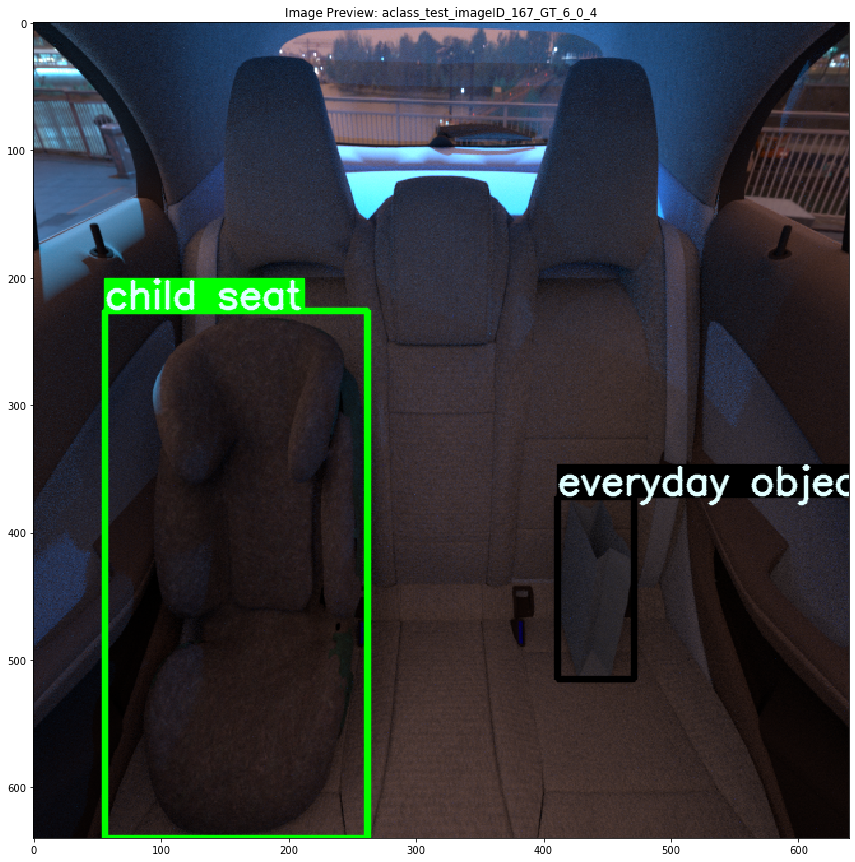

In [37]:
# Visualizing the results

# All labels files, for visualization
all_labels = glob('./runs/val/test_bosh_colab/labels/*.*')

# Get a random image from train set and plot to check

# Get random image and name
img_num = np.random.choice(len(all_labels))
img_name = all_labels[img_num].split('/')[-1].split('.')[0]

# Open the image with OpenCV
pic = cv2.imread(image_path + 'test/' + img_name + '.png')
pic = cv2.resize(pic, (640,640))

# Get image box coordenates

label_pred = pd.read_table('./runs/val/test_bosh_colab/labels/' + img_name + '.txt', names=['cls'])
box_coords_pred = list()
for box in label_pred['cls']:
    label, x, y, w, h, score = list(map(float, box.split()))
    x1, y1, x2, y2 = unconvert(640, 640, x, y, w, h)
    if score > 0.3:
        box_coords_pred.append([label, x1, y1, x2, y2])


# Plot image
returned_true = plot_image_cropped_new(pic, box_coords_pred)
plt.figure(figsize=(15,15))
plt.title('Image Preview: {}'.format(img_name))
plt.imshow(returned_true)
plt.show()

# Confusion Matrix generated by the yolo output

<img src="confusion_matrix.png">